In [1]:
from watclaimdata import test_df,train_df,valid_df

import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re
import pandas as pd

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

2023-11-05 15:07:59.387226: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_df.tail()

,claim,id,rating,original_rating
26971,"If an individual is determined ""to commit suic...",26972,1,barely-true
26972,Former NBA star said modern basketball players...,26973,0,false
26973,"""Since Debbie Halvorson has been in politics, ...",26974,1,half-true
26974,"President Barack Obama ""had the legal authorit...",26975,2,true
26975,Photograph of a Congress worker protesting aga...,26976,0,false


<AxesSubplot:>

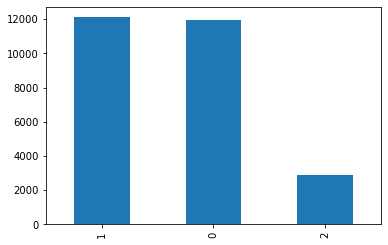

In [3]:
train_df['rating'].value_counts().plot(kind='bar')

In [4]:
# check version number
import imblearn
print(imblearn.__version__)

0.9.0


NearMiss-3 selects the closest examples from the majority class for each minority class.

The n_neighbors_ver3 argument determines the number of examples to select for each minority example, although the desired balancing ratio set via sampling_strategy will filter this to achieve the desired balance.

In [5]:
X = train_df.iloc[:,1:2]
X.shape

(26976, 1)

In [6]:
y = train_df['rating']
y.shape

(26976,)

In [7]:
valid_df['indx'] = valid_df.index

In [8]:
valid_df.head()

,claim,id,rating,original_rating,indx
0,"Video shows that ""Joe Biden participated in 'B...",26977,0,false,0
1,"""While Act 10 allowed (Milwaukee County) to sa...",26978,1,half-true,1
2,"""In Massachusetts, Biden’s vote exceeded exit ...",26979,0,false,2
3,Reliance supplying Jio Atta after farm bills w...,26980,0,false,3
4,Photo of maulvi and MP Shafiqur Rahman Virk pe...,26981,0,false,4


In [9]:
X_v = valid_df[['indx']]
y_v = valid_df['rating']
X_v.shape

(3372, 1)

In [10]:
# define the undersampling method
# undersample = NearMiss(version=3)

from imblearn.over_sampling import SMOTE


# define the undersampling method
oversample = SMOTE()
# transform the dataset
X_over, y_over = oversample.fit_resample(X, y.ravel())
Xv_over, yv_over = oversample.fit_resample(X_v, y_v.ravel())

from imblearn.under_sampling import NearMiss


# define the undersampling method
undersample = NearMiss(n_neighbors_ver3=3)
# transform the dataset
X_near, y_near = undersample.fit_resample(X, y.ravel())
Xv_near, yv_near = undersample.fit_resample(X_v, y_v.ravel())


In [11]:
print("After Oversampling, counts of label '1': {}".format(sum(y_over == 1))) 
print("After Oversampling, counts of label '0': {}".format(sum(y_over == 0))) 
print("After Oversampling, counts of label '2': {}".format(sum(y_over == 2))) 

print("After Undersampling, counts of label '1': {}".format(sum(y_near == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_near == 0))) 
print("After Undersampling, counts of label '2': {}".format(sum(y_near == 2))) 

After Oversampling, counts of label '1': 12105
After Oversampling, counts of label '0': 12105
After Oversampling, counts of label '2': 12105
After Undersampling, counts of label '1': 2894
After Undersampling, counts of label '0': 2894
After Undersampling, counts of label '2': 2894


In [12]:
over_idx = X_over['id'].apply(lambda x: x-1).tolist()
train_over_df = train_df.loc[over_idx]

over_v_idx = Xv_over['indx'].tolist()
valid_over_df = valid_df.loc[over_v_idx]

In [13]:
near_idx = X_near['id'].apply(lambda x: x-1).tolist()
train_near_df = train_df.loc[near_idx]

near_v_idx = Xv_near['indx'].tolist()
valid_near_df = valid_df.loc[near_v_idx]

In [14]:
train_near_df['rating'].unique()

array([0, 1, 2])

In [15]:
train_near_df[train_near_df['rating'] == 0][:5]

,claim,id,rating,original_rating
40,Indians in Spain celebrating Ram Mandir constr...,41,0,false
419,"Says ""Nancy Pelosi came out in favor of MS-13.""",420,0,false
874,Muslims punished for breaking lockdown in India,875,0,false
1629,Photo of Narendra Modi's mother in an auto-ric...,1630,0,false
1705,"President Donald Trump’s budget ""threatened to...",1706,0,false


In [16]:
train_near_df[train_near_df['rating'] == 1][:5]

,claim,id,rating,original_rating
1008,"The number of people who ""believe in socialism...",1009,1,half-true
6412,An image shows animals burning in the Australi...,6413,1,barely-true
7457,"Donald Trump would ""engage in a risky scheme t...",7458,1,barely-true
7635,A photograph shows a nude man walking the runw...,7636,1,miscaptioned
8675,Anyone bringing supplies to DAPL protesters at...,8676,1,mostly true


In [17]:
train_near_df[train_near_df['rating'] == 2][:5]

,claim,id,rating,original_rating
13,"Says that U.S. Rep. Allen West is ""a constitue...",14,2,true
14,"""The average margin of victory in the House of...",15,2,true
25,"""Not a single Democrat opposed Neil Gorsuch's ...",26,2,true
28,"Ted Livingston, the CEO of Kik Interactive, an...",29,2,true
31,There are cities and counties in Georgia that ...,32,2,true


In [18]:
train_df['new_rating'] = np.where(train_df['rating'] == 0,'false',np.where(train_df['rating'] == 1,'misleading',np.where(train_df['rating'] == 2,'true','')))
train_df['new_rating'].unique()

# test_df['new_rating'] = np.where(test_df['rating'] == 0,'false',np.where(test_df['rating'] == 1,'misleading',np.where(test_df['rating'] == 2,'true','')))
valid_df['new_rating'] = np.where(valid_df['rating'] == 0,'false',np.where(valid_df['rating'] == 1,'misleading',np.where(valid_df['rating'] == 2,'true','')))



In [19]:
train_over_df['new_rating'] = np.where(train_over_df['rating'] == 0,'false',np.where(train_over_df['rating'] == 1,'misleading',np.where(train_over_df['rating'] == 2,'true','')))
train_over_df['new_rating'].unique()

test_df['new_rating'] = np.where(test_df['rating'] == 0,'false',np.where(test_df['rating'] == 1,'misleading',np.where(test_df['rating'] == 2,'true','')))
valid_over_df['new_rating'] = np.where(valid_over_df['rating'] == 0,'false',np.where(valid_over_df['rating'] == 1,'misleading',np.where(valid_over_df['rating'] == 2,'true','')))



In [20]:
train_near_df['new_rating'] = np.where(train_near_df['rating'] == 0,'false',np.where(train_near_df['rating'] == 1,'misleading',np.where(train_near_df['rating'] == 2,'true','')))
train_near_df['new_rating'].unique()

# test_df['new_rating'] = np.where(test_df['rating'] == 0,'false',np.where(test_df['rating'] == 1,'misleading',np.where(test_df['rating'] == 2,'true','')))
valid_near_df['new_rating'] = np.where(valid_near_df['rating'] == 0,'false',np.where(valid_near_df['rating'] == 1,'misleading',np.where(valid_near_df['rating'] == 2,'true','')))



In [21]:

dummy_train_y = np.array(pd.get_dummies(train_df['new_rating']))
dummy_train_over_y = np.array(pd.get_dummies(train_over_df['new_rating']))
dummy_train_near_y = np.array(pd.get_dummies(train_near_df['new_rating']))


dummy_test_y = np.array(pd.get_dummies(test_df['new_rating']))

dummy_valid_y = np.array(pd.get_dummies(valid_df['new_rating']))
dummy_valid_near_y = np.array(pd.get_dummies(valid_near_df['new_rating']))
dummy_valid_over_y = np.array(pd.get_dummies(valid_over_df['new_rating']))


In [25]:
train_df[:5]

,claim,id,rating,original_rating,new_rating
0,OpIndia claimed Greta Thunberg's real name is ...,1,0,false,false
1,"“38,000 prisoners were released from federal p...",2,1,misleading,misleading
2,Says Wisconsin ‘could compel’ Foxconn to insta...,3,1,barely-true,misleading
3,A 4-year-old boy was accused of hacking the FB...,4,0,false,false
4,Whistleblower accusing Philippine VP of fraud ...,5,1,misleading,misleading


In [31]:
from transformers import BertTokenizer, TFBertModel

from transformers import logging
logging.set_verbosity_error()

In [34]:
train_df['claim'].values.tolist()[:4]

["OpIndia claimed Greta Thunberg's real name is Ghazala bhat",
 '“38,000 prisoners were released from federal prison” during the Obama administration.',
 'Says\xa0Wisconsin ‘could compel’ Foxconn to install solar panels that would power 33,000 homes.',
 "A 4-year-old boy was accused of hacking the FBI's databases."]

In [35]:
np.array(train_df['rating'].values.tolist())[:4]

array([0, 1, 1, 0])

In [36]:
train_examples = train_df['claim'].values.tolist()
train_examples = tf.convert_to_tensor(train_examples)
train_labels = np.array(train_df['rating'].values.tolist())

train_over_examples = train_over_df['claim'].values.tolist()
train_over_examples = tf.convert_to_tensor(train_over_examples)
train_over_labels = np.array(train_over_df['rating'].values.tolist())

train_near_examples = train_near_df['claim'].values.tolist()
train_near_examples = tf.convert_to_tensor(train_near_examples)
train_near_labels = np.array(train_near_df['rating'].values.tolist())


test_examples = test_df['claim'].values.tolist()
test_examples = tf.convert_to_tensor(test_examples)
test_labels = np.array(test_df['rating'].values.tolist())




val_examples = valid_df['claim'].values.tolist()
val_examples = tf.convert_to_tensor(val_examples)
val_labels = np.array(valid_df['rating'].values.tolist())

val_over_examples = valid_over_df['claim'].values.tolist()
val_over_examples = tf.convert_to_tensor(val_over_examples)
val_over_labels = np.array(valid_over_df['rating'].values.tolist())

val_near_examples = valid_near_df['claim'].values.tolist()
val_near_examples = tf.convert_to_tensor(val_near_examples)
val_near_labels = np.array(valid_near_df['rating'].values.tolist())

# print('Train data contains {} with labels of {}'.format(train_examples.shape[0],train_labels['rating'].unique()))

In [37]:
train_examples[:5]

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b"OpIndia claimed Greta Thunberg's real name is Ghazala bhat",
       b'\xe2\x80\x9c38,000 prisoners were released from federal prison\xe2\x80\x9d during the Obama administration.',
       b'Says\xc2\xa0Wisconsin \xe2\x80\x98could compel\xe2\x80\x99 Foxconn to install solar panels that would power 33,000 homes.',
       b"A 4-year-old boy was accused of hacking the FBI's databases.",
       b'Whistleblower accusing Philippine VP of fraud surfaces in December 2020'],
      dtype=object)>

In [38]:
# BERT Tokenization of training and test data



MAX_SEQUENCE_LENGTH = 128                 # set max_length of the input sequence

all_train_examples = [x.decode('utf-8') for x in train_examples.numpy()]
all_test_examples = [x.decode('utf-8') for x in val_examples.numpy()]

x_train = bert_tokenizer(all_train_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_train = train_labels

x_test = bert_tokenizer(all_test_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test = val_labels

In [49]:
def create_bert_classification_model(bert_model,
                                     num_train_layers=0,
                                     hidden_size = 200,
                                     dropout=0.3,
                                     learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]
    #cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)


    classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.categorical_crossentropy,
                                 metrics=['accuracy'])

    return classification_model

In [54]:
checkpoint = 'bert-base-cased'
# bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)
# bert_model = TFBertModel.from_pretrained(checkpoint)

bert_model = TFBertModel.from_pretrained(checkpoint)
bert_classification_model = create_bert_classification_model(bert_model, num_train_layers=0)

In [55]:
#confirm all layers are frozen
bert_classification_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 128)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                    

In [56]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    dummy_train_y,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], dummy_valid_y),
    batch_size=32,
    epochs=2
)

Epoch 1/2
843/843 [==============================] - 4051s 5s/step - loss: 0.9522 - accuracy: 0.5330 - val_loss: 0.9011 - val_accuracy: 0.5910
Epoch 2/2
843/843 [==============================] - 4260s 5s/step - loss: 0.9028 - accuracy: 0.5765 - val_loss: 0.8964 - val_accuracy: 0.5887


In [99]:
# bert_score = bert_classification_model.evaluate(train_input,dummy_train_y)
# print("%s: %.2f%%" % (bert_classification_model.metrics_names[1], bert_score[1]*100))

# y_pred = bert_classification_model.predict(test_input, batch_size=64, verbose=1)
# y_pred_bool = np.argmax(y_pred, axis=1)

# print(classification_report(t_test_labels, y_pred_bool))

843/843 [==============================] - 2s 2ms/step - loss: 0.8999 - accuracy: 0.5615
accuracy: 56.15%
53/53 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.64      0.53      0.58      1516
           1       0.56      0.47      0.51      1496
           2       0.19      0.45      0.27       360

    accuracy                           0.50      3372
   macro avg       0.46      0.49      0.45      3372
weighted avg       0.56      0.50      0.52      3372

